to accompany the write up at https://www.arjunrana.com/projects/self-storage_demand

In [1]:
import numpy as np, pandas as pd, seaborn as sns
from matplotlib import pyplot as plt
from sklearn import metrics

In [2]:
keys = pd.read_excel('data/ZIP_CBSA_122021.xlsx', dtype={'zip':'string'})
keys = keys[['cbsa', 'zip']]
locs = pd.read_csv('data/property locations hashed.csv', dtype={'Zip': 'string'})
locs = locs.rename(columns=dict(zip(locs.columns, locs.columns.str.lower())))
acs = pd.read_csv('data/acs2020_v2.csv')
var_names = pd.read_csv('data/acs2020_v2_variable_names.csv')

In [3]:
# parameters for training
SEED = 42
FOLDS = 3

#for permutation importance
N_RUNS = 100

#cutoff criterion for feature reduction clustering
T_CUTOFF=0.6

## Helper functions

In [4]:
#SMAPE for lightGBM feval
def feval_smape(preds, eval_data):
    N = eval_data.num_data()
    eval_result = np.sum( np.abs((eval_data.get_label() - preds)) / (np.abs(eval_data.get_label()) + np.abs(preds))/2) / N
    eval_name = 'smape'
    is_higher_better = False
    return eval_name, eval_result, is_higher_better

In [5]:
def mape(y_true, y_pred, return_array=False):
    assert len(y_true) == len(y_pred)
    N = len(y_true)
    if return_array:
        return np.abs((y_true - y_pred) / y_true)
    else:
        return np.sum(np.abs((y_true - y_pred) / y_true)) / N

In [6]:
def smape(y_true, y_pred, return_array=False):
    assert len(y_true) == len(y_pred)
    N = len(y_true)
    if return_array:
        return np.abs((y_true - y_pred)) / (np.abs(y_true) + np.abs(y_pred))/2
    else:
        return np.sum( np.abs((y_true - y_pred)) / (np.abs(y_true) + np.abs(y_pred))/2) / N    

In [7]:
#MAPE for N tail points
def oof_tail_MAPE(oof, N=10):
    oof_sorted = oof.sort_values(by='target')
    y_true = oof_sorted['target']
    y_pred = oof_sorted['oof_pred']
    
    return metrics.mean_absolute_percentage_error(y_true.iloc[-N:], y_pred.iloc[-N:])

In [8]:
# plot predictions sorted by target value and tail error on last N points
def plot_pred_sorted(oof, N=10, title=''):
    oof_sorted = oof.sort_values(by='target').reset_index()
    fig, ax = plt.subplots(figsize=(9,6))
    g = sns.lineplot(data=oof_sorted['target'], ax=ax, label='target')
    g2 = sns.lineplot(data=oof_sorted['oof_pred'], ax=ax, label='oof_pred')
    tail_mape = oof_tail_MAPE(oof, N=N)
    ax.set_title(title + f'MAPE(N_tail=10): {tail_mape:.2f}')
    ax.set_ylabel('Sq. Ft.')
    ax.set_xticks([])

In [9]:
#plot null distribution and true importance for 'feature'
def plot_perm_importance(true, nulls, feature, title=None):
    
    fig, ax = plt.subplots(figsize=(9,6))
    a = ax.hist(nulls.loc[feature,:].dropna().values,
               label='null',
               )
    ax.vlines(x=true[true.feature == feature].importance,
             ymin=0, 
             ymax=np.max(a[0]),
             color='r',
             linewidth=5,
             label='true',
             )
    ax.set_ylabel('counts')
    
    if title:
        ax.set_title(title)
    else:
        ax.set_title(f'permutation importance: {feature}')
    
    ax.legend()

## convert zip codes to cbsa

In [10]:
locs = locs.merge(keys, on='zip', how='left')
locs_agg = locs.groupby('cbsa')['area'].agg(['sum', 'count']).reset_index()
acs = acs.rename(columns={'metropolitan statistical area/micropolitan statistical area':'cbsa'})

#aggregate square footage by cbsa
train = acs.merge(locs_agg[['cbsa', 'sum']], on='cbsa', how='right')
train = train.rename(columns={'sum':'target'})


In [11]:
#drop NaN and single valued columns
train = train.dropna()
keep_ = [c_ for c_ in train.columns if train[c_].nunique() > 1]
train = train[keep_]

In [12]:
#remove race related columns to prevent unfair bias 
drop_list = var_names[var_names['label'].str.contains('race', case=False)]['code'].to_list()
train = train.drop(columns=[c_ for c_ in train.columns if c_ in drop_list])

dedupe(note: doesn't scale to large DF):

In [13]:
train = train.T.drop_duplicates().T

## clustering

the data are highly degenerate:

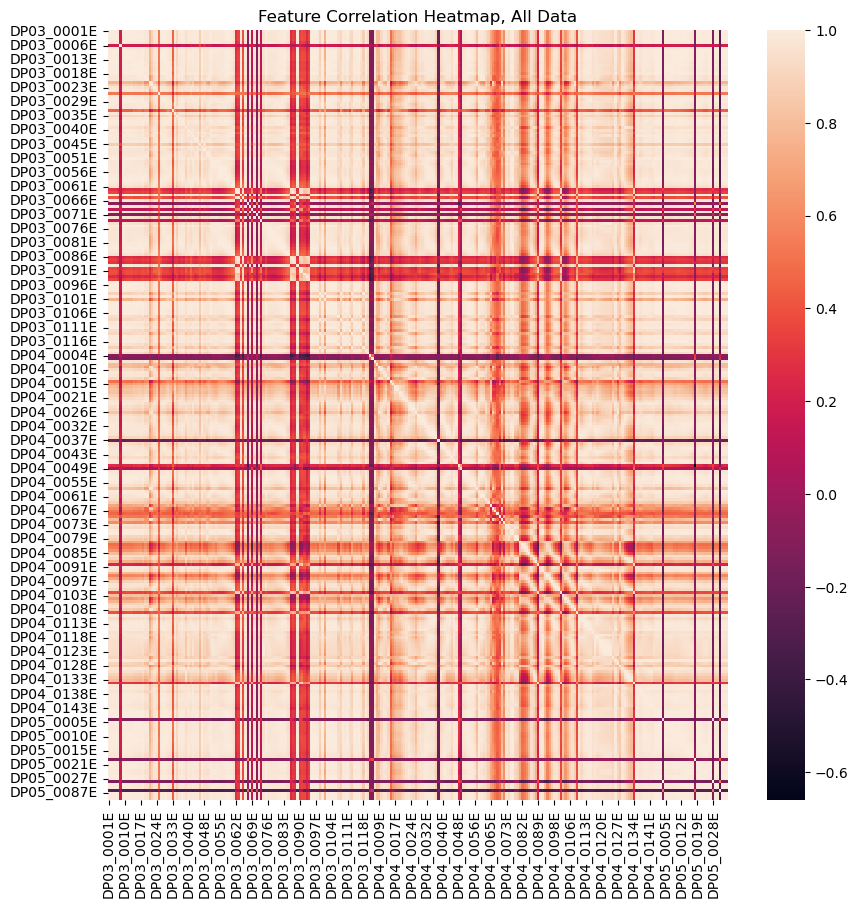

In [14]:
FEATURES = train.columns[1:-1]

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(data=train[FEATURES].corr(), ax=ax)
ax.set_title('Feature Correlation Heatmap, All Data');

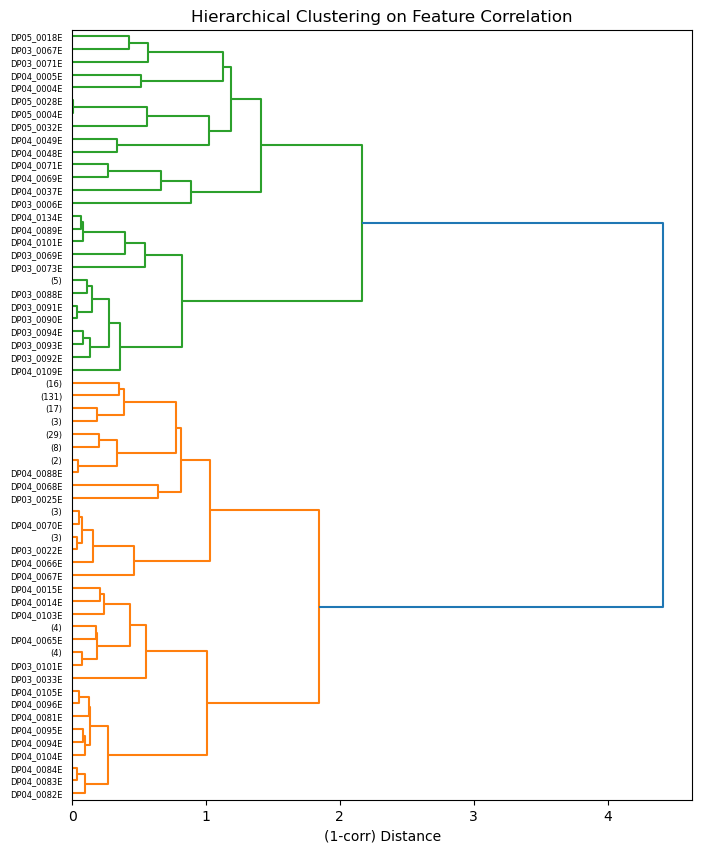

In [15]:
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform

corrs = train[FEATURES].corr().to_numpy()
corrs = (corrs + corrs.T) / 2
np.fill_diagonal(corrs, 1)

distance_matrix = 1 - np.abs(corrs)
dist_linkage = hierarchy.ward(squareform(distance_matrix))


fig, ax1 = plt.subplots(figsize=(8,10))
dendro = hierarchy.dendrogram(
    dist_linkage,
    labels = FEATURES,
    orientation='right',
    truncate_mode='level',
    p=6,
    ax=ax1,
)

ax1.set_xlabel('(1-corr) Distance')
ax1.set_title('Hierarchical Clustering on Feature Correlation');

In [16]:
from collections import defaultdict

cluster_ids = hierarchy.fcluster(dist_linkage, t=T_CUTOFF, criterion='distance')
cluster_id_to_feature_ids = defaultdict(list)

for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)

FEATURES_CLUST = [v[0] for v in cluster_id_to_feature_ids.values()]
DEDUPE_FEATURES = FEATURES[FEATURES_CLUST]

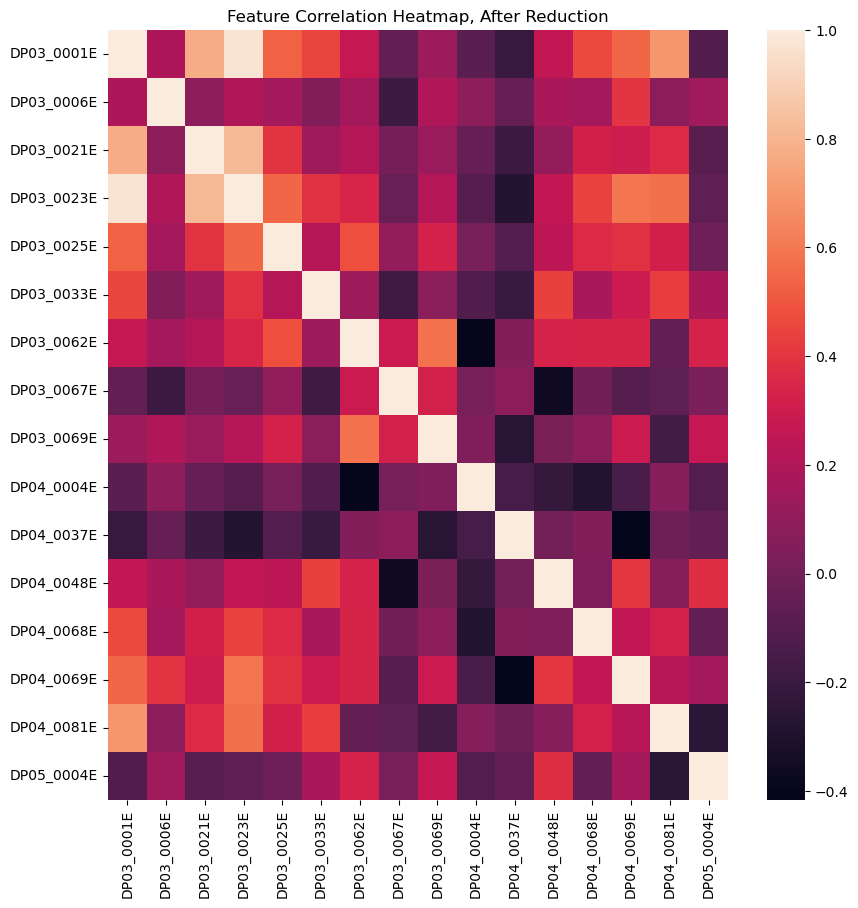

In [17]:
corrs = train.loc[:, DEDUPE_FEATURES].corr()
fig, ax = plt.subplots(figsize=(10,10))
g = sns.heatmap(corrs, ax=ax)
g.set_title('Feature Correlation Heatmap, After Reduction');

## target skew:

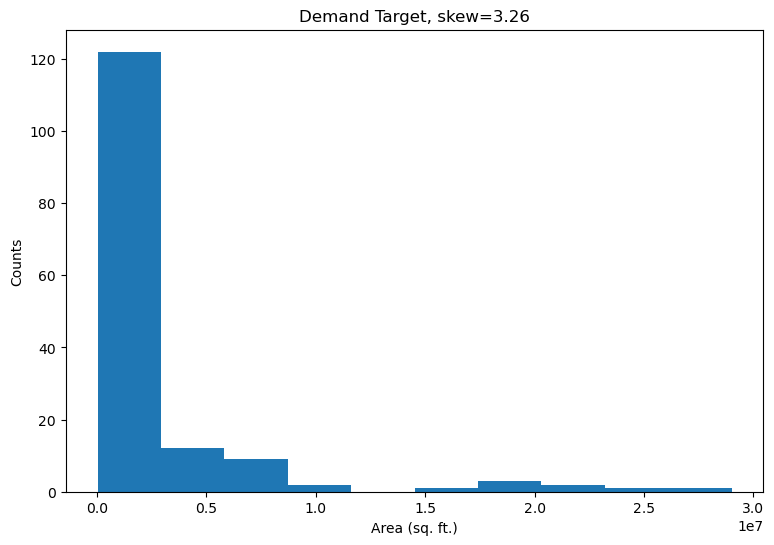

In [18]:
fig, ax = plt.subplots(figsize=(9,6))

train['target'].hist(ax=ax, grid=False);
ax.set_title(f"Demand Target, skew={train['target'].skew():.2f}")
ax.set_xlabel('Area (sq. ft.)')
ax.set_ylabel('Counts');

## single training run

In [19]:
from sklearn.model_selection import KFold
import lightgbm as lgb
print('LightGBM Version',lgb.__version__)

LightGBM Version 3.3.2


In [20]:
def lgb_CV_oof(train, features, lgb_params, folds, seed, feval=None):
    oof = []
    skf = KFold(n_splits=folds, shuffle=True, random_state=seed)

    for fold,(train_idx, valid_idx) in enumerate(skf.split(
            train, train.target )):

        print('#'*25)
        print(f'Fold {fold+1}/{folds}')
        print(f'train size {len(train_idx)}, valid size {len(valid_idx)}')
        print('#'*25)

        X_train = train.loc[train_idx, features]
        y_train = train.loc[train_idx, 'target']

        X_valid = train.loc[valid_idx, features]
        y_valid = train.loc[valid_idx, 'target']

        model = lgb.train(
            params = lgb_params,
            train_set = lgb.Dataset(data=X_train, label=y_train),
            num_boost_round = 9999,
            valid_sets = [lgb.Dataset(data=X_valid, label=y_valid)],
            callbacks = [lgb.early_stopping(100), lgb.log_evaluation(-1)],
            feval=feval
            )

        # OOF INFERENCE FOLD K
        oof_preds = model.predict(data=X_valid)

        # SAVE OOF
        df = train.loc[valid_idx, ['cbsa','target'] ].copy()

        df['oof_pred'] = oof_preds

        oof.append(df)

    print('DONE')
    oof = pd.concat(oof,axis=0,ignore_index=True).set_index('cbsa')
    return oof, model

In [21]:
LGB_PARAMS = {
     'learning_rate': 0.01,
     'objective': 'tweedie',
     'metric': 'custom', 
     'tweedie_variance_power': 1.05,
     'seed': SEED,
     'n_jobs': -1,
     'verbosity': -1,
}

oof_tweedie, model_tweedie = lgb_CV_oof(train, 
                                features=DEDUPE_FEATURES,
                                lgb_params=LGB_PARAMS, 
                                folds=FOLDS, 
                                seed=SEED,
                                feval=feval_smape
                               )

#########################
Fold 1/3
train size 102, valid size 51
#########################
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[827]	valid_0's smape: 0.165573
#########################
Fold 2/3
train size 102, valid size 51
#########################
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[713]	valid_0's smape: 0.156532
#########################
Fold 3/3
train size 102, valid size 51
#########################
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[878]	valid_0's smape: 0.146995
DONE


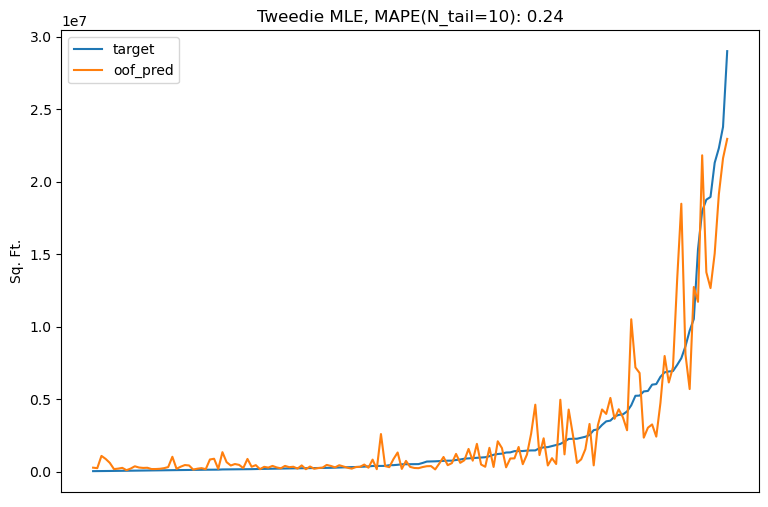

In [22]:
plot_pred_sorted(oof_tweedie, title='Tweedie MLE, ')

### L2 minimization

In [23]:
LGB_PARAMS = {
     'learning_rate': 0.01,
     'seed': SEED,
     'n_jobs': -1,
     'verbosity': -1,
}

oof_l2, model_l2 = lgb_CV_oof(train, 
                                features=DEDUPE_FEATURES,
                                lgb_params=LGB_PARAMS, 
                                folds=FOLDS, 
                                seed=SEED,
                               )

#########################
Fold 1/3
train size 102, valid size 51
#########################
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1255]	valid_0's l2: 1.30577e+13
#########################
Fold 2/3
train size 102, valid size 51
#########################
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[445]	valid_0's l2: 8.79044e+12
#########################
Fold 3/3
train size 102, valid size 51
#########################
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[131]	valid_0's l2: 7.03964e+12
DONE


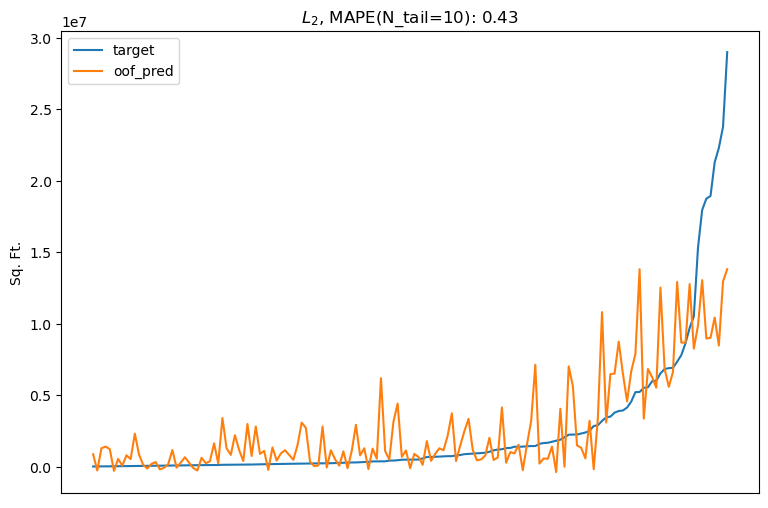

In [24]:
plot_pred_sorted(oof_l2, title=r'$L_2$, ')

### L2 with Log(Target)

In [25]:
log_train = train.copy()
log_train['target'] = np.log(log_train['target'])
log_train.head()

,cbsa,DP03_0001E,DP03_0002E,DP03_0003E,DP03_0004E,DP03_0005E,DP03_0006E,DP03_0007E,DP03_0010E,DP03_0011E,...,DP05_0026E,DP05_0027E,DP05_0028E,DP05_0030E,DP05_0031E,DP05_0032E,DP05_0087E,DP05_0088E,DP05_0089E,target
0,10420.0,577639.0,374483.0,374132.0,352385.0,21747.0,351.0,203156.0,299966.0,180825.0,...,268679.0,290862.0,92.4,54516.0,69250.0,78.7,544463.0,260602.0,283861.0,11.615644
1,10740.0,738173.0,448964.0,445261.0,418828.0,26433.0,3703.0,289209.0,378689.0,215417.0,...,346824.0,366556.0,94.6,68772.0,84720.0,81.2,674374.0,326632.0,347742.0,13.739976
2,10900.0,686513.0,440156.0,439809.0,415685.0,24124.0,347.0,246357.0,353039.0,210041.0,...,321836.0,342255.0,94.0,66634.0,85090.0,78.3,634367.0,306867.0,327500.0,11.865833
3,11460.0,307963.0,197775.0,197699.0,188718.0,8981.0,76.0,110188.0,156544.0,94769.0,...,147463.0,152300.0,96.8,22984.0,28353.0,81.1,277824.0,136071.0,141753.0,12.449815
4,12060.0,4665137.0,3130806.0,3125882.0,2962178.0,163704.0,4924.0,1534331.0,2442890.0,1520829.0,...,2136060.0,2359166.0,90.5,315852.0,414636.0,76.2,4102987.0,1932245.0,2170742.0,16.545175


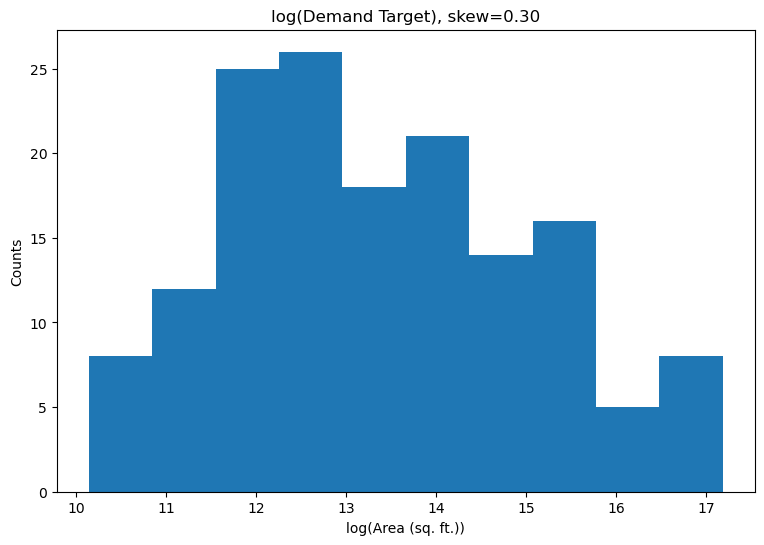

In [26]:
fig, ax = plt.subplots(figsize=(9,6))
log_train['target'].hist(ax=ax, grid=False);

ax.set_title(f"log(Demand Target), skew={log_train['target'].skew():.2f}")
ax.set_xlabel('log(Area (sq. ft.))')
ax.set_ylabel('Counts');


In [27]:
LGB_PARAMS = {
     'learning_rate': 0.001,
     'seed': SEED,
     'n_jobs': -1,
     'verbosity': -1,
}

oof_log, _ = lgb_CV_oof(log_train, 
                        features=DEDUPE_FEATURES,
                    lgb_params=LGB_PARAMS, 
                    folds=FOLDS, 
                    seed=SEED,
                   )

#########################
Fold 1/3
train size 102, valid size 51
#########################
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[9473]	valid_0's l2: 0.675277
#########################
Fold 2/3
train size 102, valid size 51
#########################
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[2118]	valid_0's l2: 0.998387
#########################
Fold 3/3
train size 102, valid size 51
#########################
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1810]	valid_0's l2: 0.830978
DONE


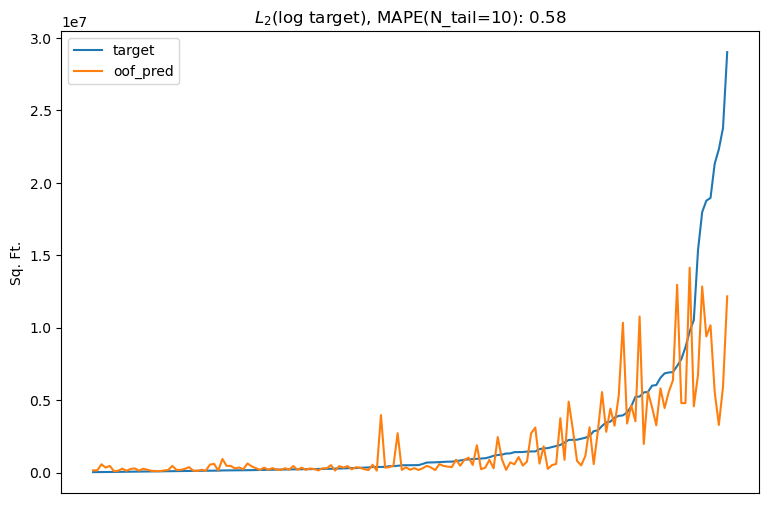

In [28]:
plot_pred_sorted(np.exp(oof_log), title=r'$L_2$(log target), ')

## Permutation Importance

In [29]:
def get_null_importances(train, features, lgb_params, folds, seed, feval=None):
    importances = []
    oof = []
    
    #training targets are shuffled
    train['target'] = rng.choice(train['target'], size=len(train['target']), replace=False)
    
    skf = KFold(n_splits=folds, shuffle=True, random_state=seed)
    
    for fold,(train_idx, valid_idx) in enumerate(skf.split(
            train, train.target )):

        X_train = train.loc[train_idx, features]
        y_train = train.loc[train_idx, 'target']

        X_valid = train.loc[valid_idx, features]
        y_valid = train.loc[valid_idx, 'target']

        model = lgb.train(
            params = lgb_params,
            train_set = lgb.Dataset(data=X_train, label=y_train),
            num_boost_round = 9999,
            valid_sets = [lgb.Dataset(data=X_valid, label=y_valid)],
            callbacks = [lgb.early_stopping(100), lgb.log_evaluation(500)],
            feval=feval
            )
        
        # df = pd.DataFrame({'feature':dd.keys(),f'importance_{fold}':dd.values()})
        df = pd.DataFrame({'feature': model.feature_name(),
                            f'gain_{fold}': model.feature_importance('gain'),
                           f'split_{fold}': model.feature_importance('split'),
                          })
        importances.append(df)
        
    imp_df = importances[0].copy()
    for k in range(1,folds): imp_df = imp_df.merge(importances[k], on='feature', how='left')
    # imp_df['importance'] = imp_df.iloc[:,1:].mean(axis=1)
    imp_df['gain_importance'] = imp_df.iloc[:,imp_df.columns.str.contains('gain')].mean(axis=1)
    imp_df['split_importance'] = imp_df.iloc[:,imp_df.columns.str.contains('split')].mean(axis=1)

    return imp_df

In [30]:
from datetime import datetime
t0 = datetime.now()
print(t0)

impts_gain = pd.DataFrame(index=DEDUPE_FEATURES)
impts_split = impts_gain.copy()

LGB_PARAMS = {
     'learning_rate': 0.001,
     'objective': 'tweedie',
     'metric': 'custom',
     'tweedie_variance_power': 1.05,
     'seed': SEED,
     'n_jobs': -1,
     'verbosity': -1,
}

#seed for random.choice
rng = np.random.Generator(np.random.PCG64(seed=SEED))

for ii in range(N_RUNS): 
    print('#'*25)
    print(f'RUN {ii+1}:{N_RUNS}')
    print('#'*25)
    
    imp_df = get_null_importances(train=train.copy(), 
                                  features=DEDUPE_FEATURES,
                                  lgb_params=LGB_PARAMS, 
                                  folds=FOLDS, 
                                  seed=SEED,
                                 feval=feval_smape)
    
    imp_gain = imp_df[['feature','gain_importance']].set_index('feature')
    impts_gain = pd.concat([impts_gain, imp_gain.reindex(impts_gain.index)], axis=1, ignore_index=True)
    
    imp_split = imp_df[['feature','split_importance']].set_index('feature')
    impts_split = pd.concat([impts_split, imp_split.reindex(impts_split.index)], axis=1, ignore_index=True)
    
    t1 = datetime.now()
    print('#'*25)
    print(f'total elapsed time: {t1-t0}')

2022-10-06 10:46:31.876024
#########################
RUN 1:100
#########################
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	valid_0's smape: 0.359427
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[382]	valid_0's smape: 0.277518
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	valid_0's smape: 0.303673
#########################
total elapsed time: 0:00:00.338775
#########################
RUN 2:100
#########################
Training until validation scores don't improve for 100 rounds
[500]	valid_0's smape: 0.314292
[1000]	valid_0's smape: 0.30706
[1500]	valid_0's smape: 0.303981
[2000]	valid_0's smape: 0.301709
Early stopping, best iteration is:
[1948]	valid_0's smape: 0.301416
Training until validation scores don't improve for 100 rounds
[500]	valid_0's smape: 0.305389
[1000]	valid_0's smape: 0.304455
[1500]	valid_0's s

In [31]:
true_impts_gain = pd.DataFrame({'feature':model_tweedie.feature_name(), 'importance': model_tweedie.feature_importance('gain')})
true_impts_split = pd.DataFrame({'feature':model_tweedie.feature_name(), 'importance': model_tweedie.feature_importance('split')})

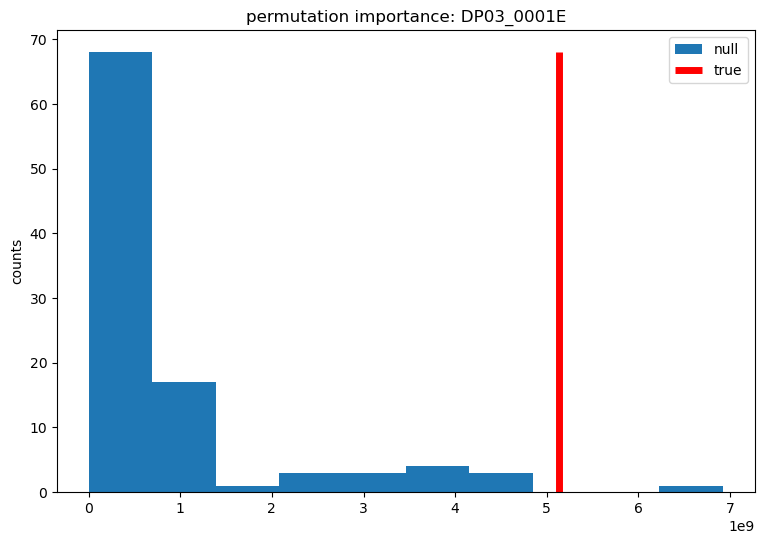

In [32]:
# example of an important feature
plot_perm_importance(true=true_impts_gain, nulls=impts_gain, feature='DP03_0001E')

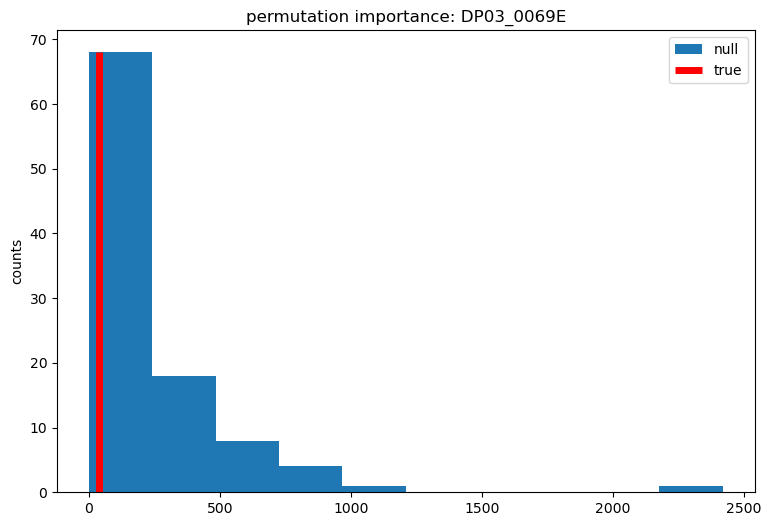

In [33]:
#example of unimportant feature
plot_perm_importance(true=true_impts_split, nulls=impts_split, feature='DP03_0069E')

In [34]:
perm_impt_gain = pd.concat([
            true_impts_gain.set_index('feature')['importance'].rename('true'),
            impts_gain.median(axis=1).reindex_like(true_impts_gain.set_index('feature')).rename('null'),
            ],
          axis=1,
         )

perm_impt_gain['true/null'] = perm_impt_gain['true'] / np.fmax(1, perm_impt_gain['null'])
perm_impt_gain = perm_impt_gain.sort_values(by='true/null', ascending=False)
perm_impt_gain['label'] = var_names.set_index('code')['label'].reindex_like(perm_impt_gain)

In [35]:
pd.options.display.max_colwidth = 999
pd.options.display.max_rows = 999
perm_impt_gain.reset_index()

,feature,true,null,true/null,label
0,DP03_0001E,5.138790e+09,1.640695e+08,31.320820,Estimate!!EMPLOYMENT STATUS!!Population 16 years and over
1,DP03_0023E,7.343464e+09,2.889974e+08,25.410137,Estimate!!COMMUTING TO WORK!!Workers 16 years and over!!Other means
2,DP03_0021E,9.789686e+08,2.265680e+08,4.320860,Estimate!!COMMUTING TO WORK!!Workers 16 years and over!!Public transportation (excluding taxicab)
3,DP03_0062E,3.868884e+08,6.690112e+08,0.578299,Estimate!!INCOME AND BENEFITS (IN 2020 INFLATION-ADJUSTED DOLLARS)!!Total households!!Median household income (dollars)
4,DP03_0025E,1.814114e+08,6.612760e+08,0.274335,Estimate!!COMMUTING TO WORK!!Workers 16 years and over!!Mean travel time to work (minutes)
5,DP04_0037E,8.945808e+07,3.905082e+08,0.229081,Estimate!!ROOMS!!Total housing units!!Median rooms
6,DP04_0048E,1.246033e+08,5.498175e+08,0.226627,Estimate!!HOUSING TENURE!!Occupied housing units!!Average household size of owner-occupied unit
7,DP03_0006E,1.589309e+08,8.798243e+08,0.180639,Estimate!!EMPLOYMENT STATUS!!Population 16 years and over!!In labor force!!Armed Forces
8,DP05_0004E,8.535969e+07,6.891944e+08,0.123854,Estimate!!SEX AND AGE!!Total population!!Sex ratio (males per 100 females)
9,DP04_0068E,4.656663e+07,6.718848e+08,0.069307,Estimate!!HOUSE HEATING FUEL!!Occupied housing units!!Wood


In [36]:
perm_impt_split = pd.concat([
            true_impts_split.set_index('feature')['importance'].rename('true'),
            impts_split.median(axis=1).reindex_like(true_impts_split.set_index('feature')).rename('null'),
            ],
          axis=1,
         )

perm_impt_split['true/null'] = perm_impt_split['true'] / np.fmax(1, perm_impt_split['null'])
perm_impt_split = perm_impt_split.sort_values(by='true/null', ascending=False)
perm_impt_split['label'] = var_names.set_index('code')['label'].reindex_like(perm_impt_split)
perm_impt_split

,true,null,true/null,label
feature,,,,
DP03_0001E,579,23.500000,24.638298,Estimate!!EMPLOYMENT STATUS!!Population 16 years and over
DP03_0023E,313,42.666667,7.335938,Estimate!!COMMUTING TO WORK!!Workers 16 years and over!!Other means
DP04_0037E,279,45.500000,6.131868,Estimate!!ROOMS!!Total housing units!!Median rooms
DP05_0004E,355,67.000000,5.298507,Estimate!!SEX AND AGE!!Total population!!Sex ratio (males per 100 females)
DP04_0068E,260,70.833333,3.670588,Estimate!!HOUSE HEATING FUEL!!Occupied housing units!!Wood
DP03_0062E,231,79.666667,2.899582,Estimate!!INCOME AND BENEFITS (IN 2020 INFLATION-ADJUSTED DOLLARS)!!Total households!!Median household income (dollars)
DP03_0025E,228,84.833333,2.687623,Estimate!!COMMUTING TO WORK!!Workers 16 years and over!!Mean travel time to work (minutes)
DP03_0006E,195,98.000000,1.989796,Estimate!!EMPLOYMENT STATUS!!Population 16 years and over!!In labor force!!Armed Forces
DP04_0048E,125,64.333333,1.943005,Estimate!!HOUSING TENURE!!Occupied housing units!!Average household size of owner-occupied unit


In [37]:
GAIN_FEATS = perm_impt_gain[perm_impt_gain['true/null'] > 1.].index
SPLIT_FEATS = perm_impt_split[perm_impt_split['true/null'] > 1.].index

In [38]:
oof_all, model_tweedie_all = lgb_CV_oof(train, 
                                        features=SPLIT_FEATS.union(GAIN_FEATS),
                                        lgb_params=LGB_PARAMS, 
                                        folds=FOLDS, 
                                        seed=SEED,
                                        feval=feval_smape
                                       )

#########################
Fold 1/3
train size 102, valid size 51
#########################
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[4639]	valid_0's smape: 0.171913
#########################
Fold 2/3
train size 102, valid size 51
#########################
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[8294]	valid_0's smape: 0.155127
#########################
Fold 3/3
train size 102, valid size 51
#########################
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[5091]	valid_0's smape: 0.154173
DONE


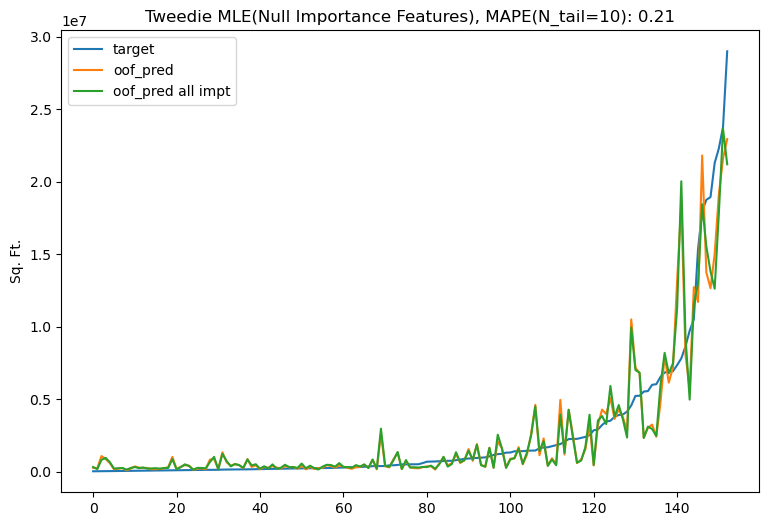

In [39]:
fig, ax = plt.subplots(figsize=(9,6))
oof_sorted = oof_tweedie.sort_values(by='target').reset_index()
oof_all_sorted = oof_all.sort_values(by='target').reset_index()
N=10
g = sns.lineplot(data=oof_all_sorted['target'], label='target', ax=ax)
g2 = sns.lineplot(data=oof_sorted['oof_pred'], label='oof_pred', ax=ax)
g3 = sns.lineplot(data=oof_all_sorted['oof_pred'], label='oof_pred all impt', ax=ax)
ax.set_ylabel('Sq. Ft.')
tail_mape = oof_tail_MAPE(oof_all_sorted, N=N)
ax.set_title('Tweedie MLE(Null Importance Features), ' + f'MAPE(N_tail=10): {tail_mape:.2f}');

# Predict on test data

In [43]:
test = acs.merge(locs_agg[['cbsa', 'sum']], on='cbsa', how='left')
test = test[test['sum'].isna()]
test = test.drop(columns='sum')

In [44]:
test_preds = pd.DataFrame(index=test.cbsa, data=model_tweedie_all.predict(test.loc[:, SPLIT_FEATS.union(GAIN_FEATS)]), columns=['test_pred'])
test_preds = test_preds.reset_index()
test_preds['cbsa'] = test_preds['cbsa'].astype('string')

# Plotly

In [45]:
from urllib.request import urlopen
import json
import plotly.express as px

In [46]:
# with open('data/tl_2021_us_cbsa.json') as geojson_file:
with open('data/tl_2021_us_cbsa_resized.json') as geojson_file:
    map_ = json.load(geojson_file)

In [ ]:
fig = px.choropleth_mapbox(
                           data_frame=test_preds,
                            geojson=map_,
                            featureidkey='properties.CBSAFP',
                            locations='cbsa', 
                            color='test_pred',
                            color_continuous_scale="Greens",
                            mapbox_style="carto-positron",
                            zoom=3, center = {"lat": 37.0902, "lon": -95.7129},
                            opacity=0.5,
                          )

fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [ ]:
# save for website
fig.write_html('data/self-storage_chloro_map.html')

# External Data Sources
- demographic data(2020):
    - https://www.census.gov/data/developers/data-sets/acs-5year.html
- CBSA map (2021):
    - https://www.census.gov/geographies/mapping-files/time-series/geo/cartographic-boundary.html
- zip code to cbsa:
    - https://www.huduser.gov/portal/datasets/usps_crosswalk.html